# Analyzing Gyro Bias Jog Risks (updated 2016:327)

- 2016:324 NSM was due to failed transition to NPM after maneuver from 60 deg pitch to 154 deg pitch.  
- At the start of the 324:20:20z comm Chandra was observed to be in Normal Sun Mode. The OBC error-log dump indicated the NSM entry occurred at 12:59:32z, DOY 324.

```
ObsID Target              Start     Time   SI   Grat    RA       Dec    Roll   Pitch   Slew
-------------------------------------------------------------------------------------------
19846 HZ43   2016:324:11:48:20.079   2.0  HRC-I LETG 199.0834  29.0806  39.79  59.77 115.31
19942 Ae Aur 2016:324:12:58:16.839  29.0 ACIS-I NONE  79.1156  34.2873 121.98 154.15  95.01
```



### Set up environment

* Normal CXC-custom imports

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from Ska.engarchive import fetch_eng as fetch
from kadi import events
from Chandra.Time import DateTime, date2secs
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate

### Define input variables

In [3]:
t_start = '2016:200' #first recorded bias jog was 2010:208
t_stop = None

### Collect bias telemetry data

* Fetch 5-minute sample bias data 
* Remove maneuvers, NSM, & SSM events
* Convert to deg/hr
* Plot

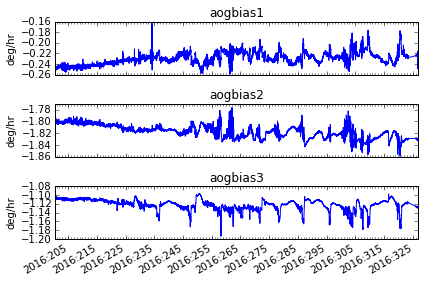

In [4]:
msids = ['aogbias1', 'aogbias2', 'aogbias3']
x = fetch.Msidset(msids, t_start, t_stop, stat='5min')

for msid in msids:
    x[msid].remove_intervals(events.normal_suns(pad=24*3600))
    x[msid].remove_intervals(events.safe_suns(pad=24*3600))
    x[msid].remove_intervals(events.manvrs(pad=600))

b1 = x['aogbias1'].midvals*206264.806247 # rads/sec to deg/hr 
b2 = x['aogbias2'].midvals*206264.806247
b3 = x['aogbias3'].midvals*206264.806247
t = x['aogbias1'].times

figure()
zipvals = zip(arange(1,4), msids, [b1, b2, b3])
for i, msid, b in zipvals:
    subplot(3,1,i)
    plot_cxctime(x[msid].times, b)
    title(msid)
    ylabel('deg/hr')
tight_layout()
# savefig('biases.png')

### Collect maneuver data

* Fetch non-segmented maneuvers after start date with maneuver angle > 0 (to avoid sim-motions only)
* Collect maneuver duration, angle, and one-shot data
* Bin maneuvers by duration in 5-min increments
* For each bin, calculate one-shot percentile data
* Plots


Percentage of time in maneuver mode:  8.06721591683%


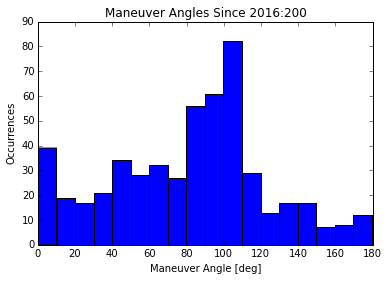

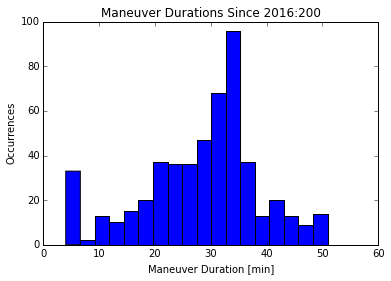

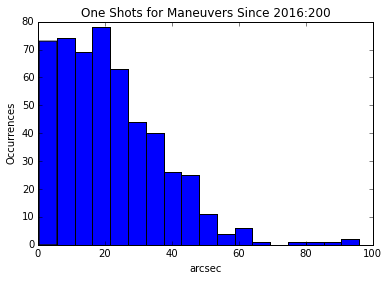

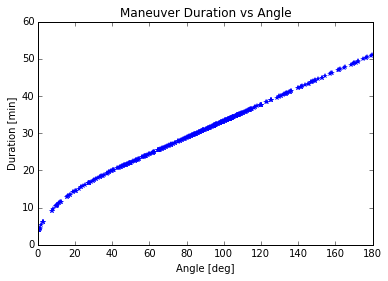

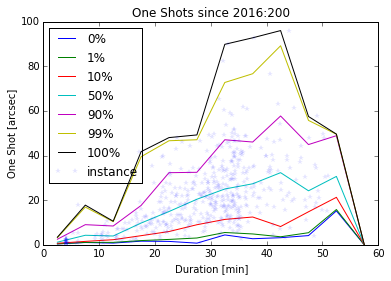

In [5]:
def remove_segmented_manvrs(manvrs):
    """
    Return maneuvers that are not segmented.  This is defined as a
    manevuer that starts at least 240 seconds after the previous one stops.
    """
    prev_manvr_tstops = date2secs(manvrs['prev_manvr_stop'])
    manvr_tstarts = date2secs(manvrs['manvr_start'])
    dts = manvr_tstarts - prev_manvr_tstops
    not_segmented = dts > 240  # Mostly they are less than 50 seconds
    return manvrs[not_segmented]

manvrs = events.manvrs.filter(start=t_start, angle__gte=0.1, one_shot__gt=0).table
manvrs = remove_segmented_manvrs(manvrs)
ang = manvrs['angle'] #deg
one_shot = manvrs['one_shot'] #arcsec
dur = manvrs['dur'] #sec

t_man_tot = sum(dur)
t_tot = DateTime(t_stop).secs - DateTime(t_start).secs 

bins = arange(0, 60, 5) #min
one_shot_perc = zeros((12, 7))

for i in arange(11):
    in_bin = (dur/60 > bins[i]) & (dur/60 < bins[i]+5)
    one_shot_perc[i, :] = percentile(one_shot[in_bin], [0,1,10,50,90,99,100])

disp('Percentage of time in maneuver mode:  ' + str(t_man_tot/t_tot*100) + '%')

figure()
hist(ang, bins=18)
title('Maneuver Angles Since ' + t_start)
ylabel('Occurrences')
xlabel('Maneuver Angle [deg]')
# savefig('man_ang.png')

figure()
hist(dur/60, bins=18)
title('Maneuver Durations Since ' + t_start)
ylabel('Occurrences')
xlabel('Maneuver Duration [min]')
# savefig('man_dur.png')

figure()
hist(one_shot, bins=18)
title('One Shots for Maneuvers Since ' + t_start)
ylabel('Occurrences')
xlabel('arcsec')
# savefig('one_shots.png')

figure()
plot(ang, dur/60, '*', mew=0)
title('Maneuver Duration vs Angle')
ylabel('Duration [min]')
xlabel('Angle [deg]')
# savefig('man_dur_vs_ang.png')

figure()
plot(bins+2.5, one_shot_perc, '-')
plot(dur/60, one_shot, 'b*', mew=0, alpha=.1)
title('One Shots since ' + t_start)
ylabel('One Shot [arcsec]')
xlabel('Duration [min]')
legend(['0%','1%','10%','50%','90%','99%','100%','instance'],loc='best')
# savefig('oneshot_vs_dur.png')


### Search for significant jogs

* For each duration bin, using independent search boxes:
   * Integrate the change in bias with respect to start time
      * Alternate calculation integrates the absolute difference
         * (I'm shocked that results are so similar...)
   * Remove non-continuous timeframes (e.g. contain maneuvers, SSM, etc)
   * Collect percentile data on the calculated changes
   * Save arrays for 30, 45, and 60 min timeframes



In [6]:
dbias_perc = zeros((12,6))
dbias_abs_perc = zeros((12,6))

for i in arange(12):  

    pad = i + 1 # bookkkeeping index for 5 min stats

    # Integrate change in bias with respect to start time
    d1 = array([sum(b1[j+1:j+1+pad] - b1[j])*5/60.0 for j in arange(0,len(b1)-pad, pad)])  #deg
    d2 = array([sum(b2[j+1:j+1+pad] - b2[j])*5/60.0 for j in arange(0,len(b2)-pad, pad)])  
    d3 = array([sum(b3[j+1:j+1+pad] - b3[j])*5/60.0 for j in arange(0,len(b3)-pad, pad)])  
    dbias = sqrt(d1**2 + d2**2 + d3**2) #deg
    
    # Alternate integration approach using absolute value of difference
    d1_abs = array([sum(abs(b1[j+1:j+1+pad] - b1[j]))*5/60.0 for j in arange(0,len(b1)-pad, pad)])  #deg
    d2_abs = array([sum(abs(b2[j+1:j+1+pad] - b2[j]))*5/60.0 for j in arange(0,len(b2)-pad, pad)])  
    d3_abs = array([sum(abs(b3[j+1:j+1+pad] - b3[j]))*5/60.0 for j in arange(0,len(b3)-pad, pad)])  
    dbias_abs = sqrt(d1_abs**2 + d2_abs**2 + d3_abs**2) #deg    
    
    # remove non-continuous timeframes 
    dt = array([t[j+pad] - t[j] for j in arange(0,len(t)-pad, pad)])  
    ok = (dt < (pad*328 + 100))
    dbias = dbias[ok]
    dbias_abs = dbias_abs[ok]
    
    # collect percentile data
    dbias_perc[i, :] = percentile(dbias, [0,50,90,99,99.9,100])
    dbias_abs_perc[i, :] = percentile(dbias_abs, [0,50,90,99,99.9,100])
    
    # for specific durations, save arrays
    if pad == 6:
       dbias_30 = dbias  
       dbias_abs_30 = dbias_abs   
    if pad == 9:
       dbias_45 = dbias
       dbias_abs_45 = dbias_abs
    if pad == 12:
       dbias_60 = dbias
       dbias_abs_60 = dbias_abs 

### Plot Results

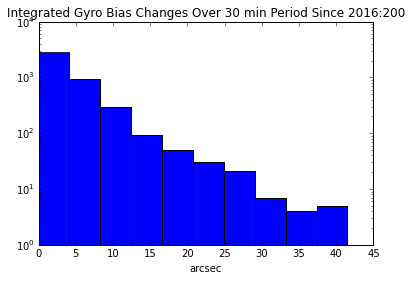

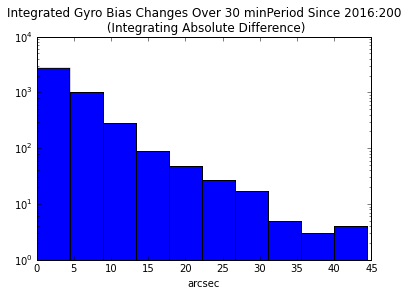

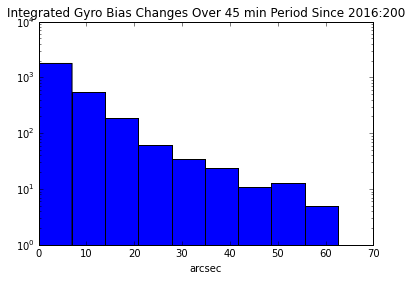

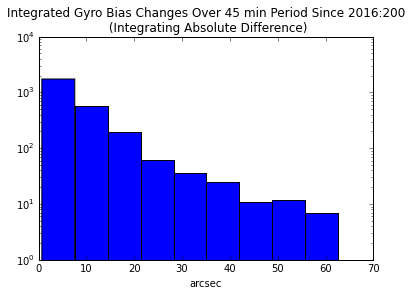

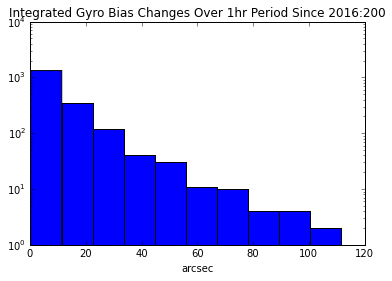

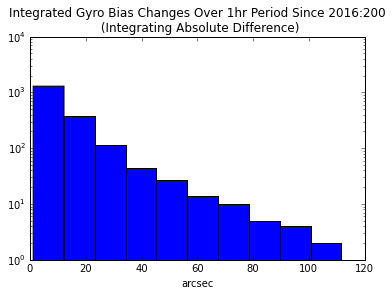

In [7]:
figure()
hist(dbias_30*3600, log=True)
title('Integrated Gyro Bias Changes Over 30 min Period Since ' + t_start)
xlabel('arcsec')
# savefig('dbias_60.png')

figure()
hist(dbias_abs_30*3600, log=True)
title('Integrated Gyro Bias Changes Over 30 minPeriod Since ' + t_start + '\n (Integrating Absolute Difference)')
xlabel('arcsec')
# savefig('dbias_abs_60.png')

figure()
hist(dbias_45*3600, log=True)
title('Integrated Gyro Bias Changes Over 45 min Period Since ' + t_start)
xlabel('arcsec')
# savefig('dbias_45.png')

figure()
hist(dbias_abs_45*3600, log=True)
title('Integrated Gyro Bias Changes Over 45 min Period Since ' + t_start + '\n (Integrating Absolute Difference)')
xlabel('arcsec')
# savefig('dbias_abs_45.png')

figure()
hist(dbias_60*3600, log=True)
title('Integrated Gyro Bias Changes Over 1hr Period Since ' + t_start)
xlabel('arcsec')
# savefig('dbias_60.png')

figure()
hist(dbias_abs_60*3600, log=True)
title('Integrated Gyro Bias Changes Over 1hr Period Since ' + t_start + '\n (Integrating Absolute Difference)')
xlabel('arcsec')
# savefig('dbias_abs_60.png')

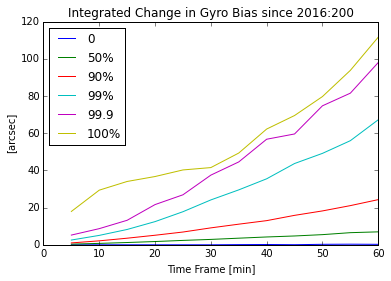

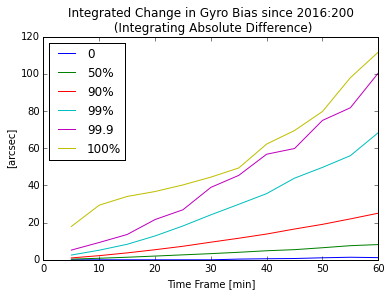

In [8]:
figure()
plot(bins+5, dbias_perc*3600, '-')
title('Integrated Change in Gyro Bias since ' + t_start)
ylabel('[arcsec]')
xlabel('Time Frame [min]')
legend(['0','50%','90%','99%','99.9','100%'],loc='best')

figure()
plot(bins+5, dbias_abs_perc*3600, '-')
title('Integrated Change in Gyro Bias since ' + t_start+ '\n (Integrating Absolute Difference)')
ylabel('[arcsec]')
xlabel('Time Frame [min]')
legend(['0','50%','90%','99%','99.9','100%'],loc='best')


In [9]:
100.0*sum(dbias_45*3600 > 50)/len(dbias_45)

0.6407840180927252

In [10]:
len(manvrs)

519

In [11]:
1.0*len(manvrs)*sum(dbias_45*3600 > 50)/len(dbias_45)

3.325669053901244

In [12]:
np.count_nonzero(manvrs['dur'] > 45 * 60)

24

In [13]:
24 / 519.

0.046242774566473986